In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

<ipython-input-30-daa25edb213e>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_by_price = df.groupby('price_bin')['Volume'].sum()


✅ Grafico salvato: nasdaq_vwap_poc.png


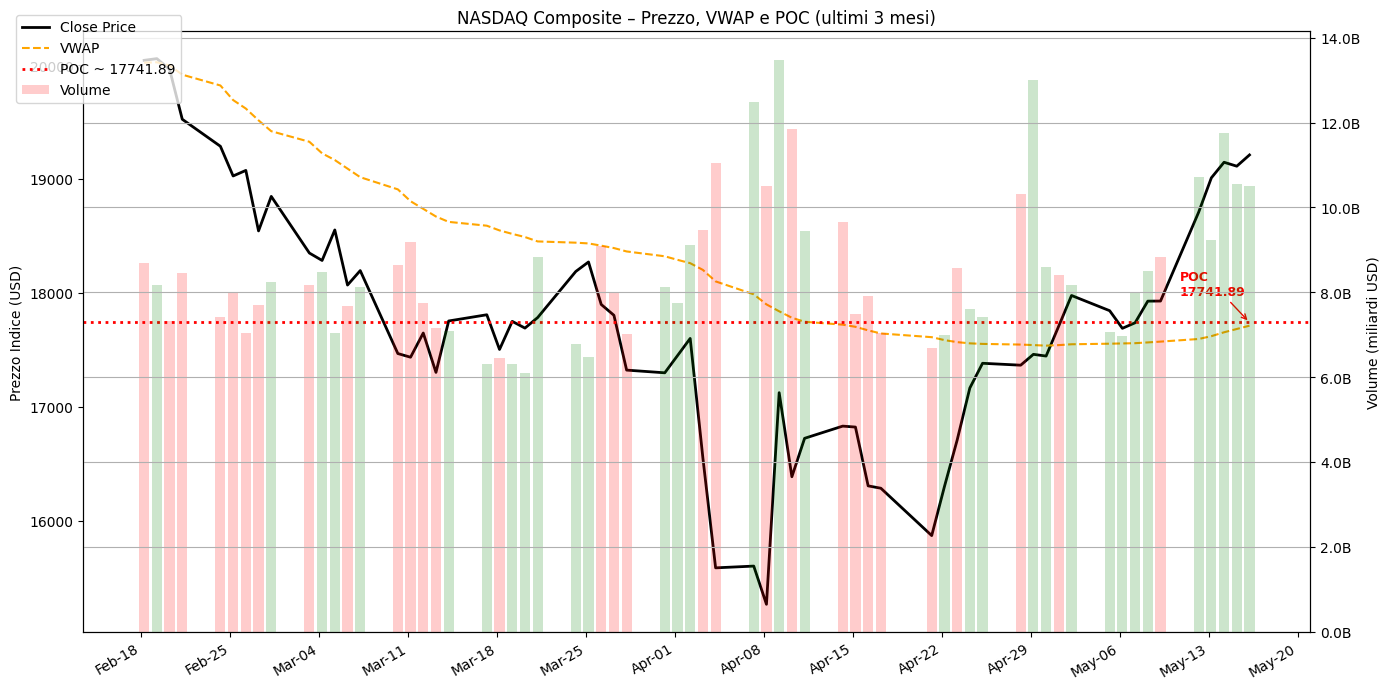

<ipython-input-30-daa25edb213e>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_by_price = df.groupby('price_bin')['Volume'].sum()


✅ Grafico salvato: sp500_vwap_poc.png


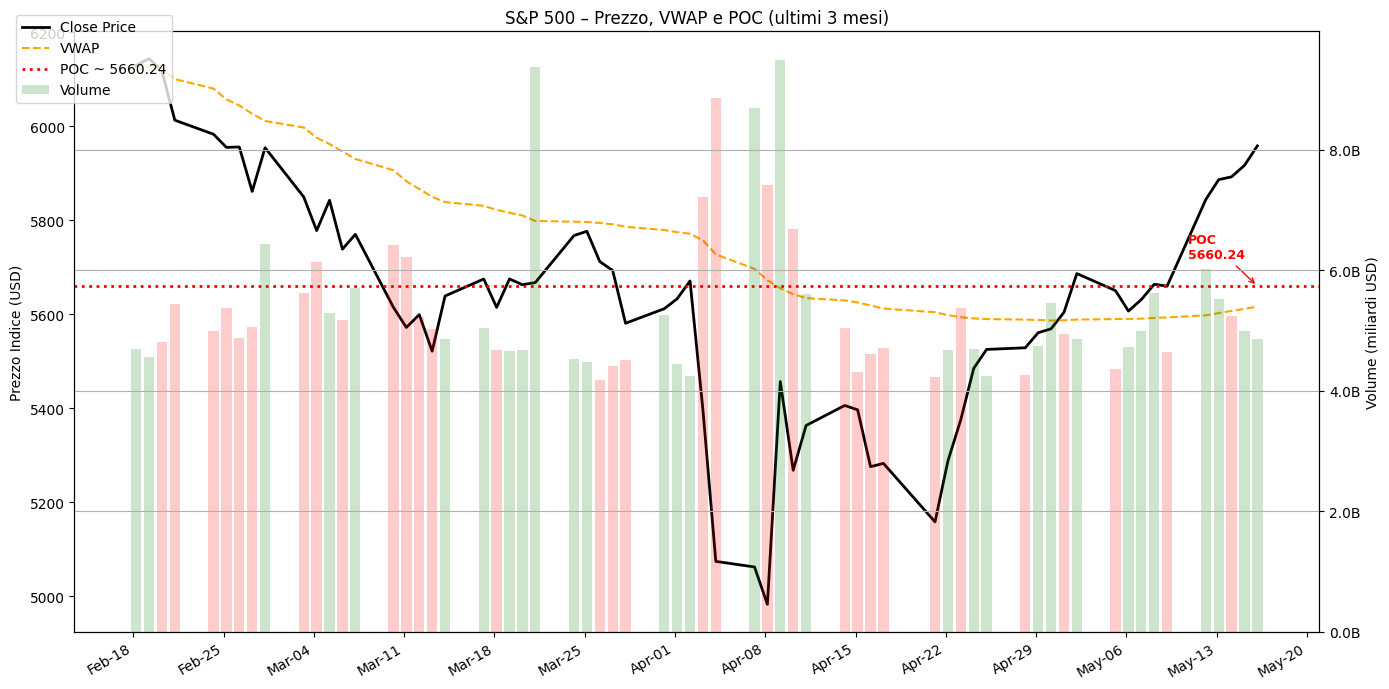

In [ ]:
def analyze_ticker(ticker_symbol, name, save_path):
    # 1. Scarica dati storici
    ticker = yf.Ticker(ticker_symbol)
    df = ticker.history(period="3mo", interval="1d").reset_index()

    if df.empty:
        print(f"⚠️ Nessun dato disponibile per {name}")
        return

    # 2. VWAP
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['VWAP'] = (typical_price * df['Volume']).cumsum() / df['Volume'].cumsum()

    # 3. POC
    df['price_bin'] = pd.cut(df['Close'], bins=30)
    volume_by_price = df.groupby('price_bin')['Volume'].sum()
    poc_bin = volume_by_price.idxmax()
    poc_price = poc_bin.mid

    # 4. Volume colorato
    df['VolumeColor'] = df['Close'] > df['Open']

    # 5. Plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(df['Date'], df['Close'], label='Close Price', linewidth=2, color='black')
    ax1.plot(df['Date'], df['VWAP'], label='VWAP', linestyle='--', color='orange')
    ax1.axhline(poc_price, color='red', linestyle=':', linewidth=2, label=f'POC ~ {poc_price:.2f}')

  # Annotazione POC
    ax1.annotate(f'POC\n{poc_price:.2f}',
             xy=(df['Date'].iloc[-1], poc_price),
             xytext=(-50, 20),  # 🔁 più a destra (da -70 a -40)
             textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red'),
             color='red', fontsize=9,
             fontweight='bold')  # 🔁 grassetto

    ax1.set_ylabel('Prezzo Indice (USD)')
    ax1.set_title(f'{name} – Prezzo, VWAP e POC (ultimi 3 mesi)')

    # Volume su secondo asse
    ax2 = ax1.twinx()
    colors = df['VolumeColor'].map({True: 'green', False: 'red'})
    ax2.bar(df['Date'], df['Volume'], color=colors, alpha=0.2, label='Volume')
    ax2.set_ylabel('Volume (miliardi USD)')
    ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x*1e-9:.1f}B'))

    # Asse X formattato
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    fig.autofmt_xdate()

    # Legenda
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0.01, 0.98))

    plt.grid(True)
    plt.tight_layout()

    # Salva e mostra
    plt.savefig(save_path, dpi=300)
    print(f"✅ Grafico salvato: {save_path}")
    plt.show()

# Analisi NASDAQ e S&P 500
analyze_ticker("^IXIC", "NASDAQ Composite", "nasdaq_vwap_poc.png")
analyze_ticker("^GSPC", "S&P 500", "sp500_vwap_poc.png")